In [1]:
import os
os.chdir('../..')
os.getcwd()

'D:\\StockMaster'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler

In [71]:
import pandas_datareader as pdr
df= pdr.get_data_yahoo('AAPL', '2000-01-01')

In [ ]:
# log 정규화
def nplog(dataframe):
    
    temp = np.log(dataframe)
    
    return temp

# indicator 계산
def get_indicators(dataframe, *indicators):
    
    from Indicator import get_Bolinger_Band
    from Indicator import get_DMI
    from Indicator import get_MACD
    from Indicator import get_RSI
    
    

    BAND = get_Bolinger_Band.fnBolingerBand
    DMI = get_DMI.cal_dmi
    MACD = get_MACD.fnMACD
    RSI = get_RSI.fnRSI
    
    
    for indicator in indicators:
        
        if indicator == 'DMI':
            DMI(dataframe)
        elif indicator == 'MACD':
            MACD(dataframe)
        elif indicator == 'RSI':
            RSI(dataframe)
        elif indicator == 'BAND':
            BAND(dataframe)
    
    dataframe.dropna(inplace=True)
    
    return dataframe

# minmax scale
def make_sc_col_df(train_scdf):
    for i in train_scdf.columns:
        globals()['scaler_{}'.format(i)] = MinMaxScaler()
        print("df_{}".format(i))
        globals()["df_{}".format(i)] = train_scdf[[i]]
        globals()["df_{}".format(i)] = globals()['scaler_{}'.format(i)].fit_transform(globals()["df_{}".format(i)])
        globals()["df_{}".format(i)] = pd.DataFrame(globals()["df_{}".format(i)])
        globals()["df_{}".format(i)].index = train_scdf.index
        globals()["df_{}".format(i)].columns = [i]

    return globals()["df_{}".format(i)]

# shift data
def shift_df(*dataframes, start=1, end=4):  
    shift_num = end
    for dataframe in dataframes:
        for s in range(start, end):
            dataframe['shift_{}'.format(s)] = dataframe[dataframe.columns[0]].shift(s)
        dataframe.dropna(inplace=True)
    return dataframe

# concat dataframe
def df_concat(*dataframes):
    all_Df =  pd.concat([*dataframes], axis=1)
    all_Df.dropna(inplace=True)
    return all_Df

# drop original values
def drop_ori_cols(all_df):
    col_list = []
    for i in all_df.columns:
        if 'shift' in i:
            pass
        elif 'Close' in i:
            pass
        else:
            col_list.append(i)
    all_df.drop(col_list, axis=1, inplace=True)
    
    return all_df

# set y target & split train test
def set_split(all_df, num=1, xnum=200):
    xdata = all_df.drop('Close', axis=1)[:-num]
    ydata = all_df['Close'][num:].values
    
    x_train = xdata[:-xnum]
    x_test = xdata[-xnum:]

    ytrain = ydata[:-xnum]
    ytest = ydata[-xnum:]
    
    shift_num = 3
    x_train = np.array(x_train).reshape(len(x_train), int(len(x_train.columns)/shift_num), shift_num)
    x_test = np.array(x_test).reshape(len(x_test), int(len(x_test.columns)/shift_num), shift_num)

    
    return x_train, x_test, ytrain, ytest

# make LSTM model
def LSTMmodel():
    from tensorflow.keras.layers import LSTM 
    from tensorflow.keras.models import Sequential 
    from tensorflow.keras.layers import Dense 
    import tensorflow.keras.backend as K 
    from tensorflow.keras.callbacks import EarlyStopping


    model3 = Sequential() # Sequeatial Model 
    model3.add(LSTM(20, input_shape=(x_train.shape[1], x_train.shape[2]))) # (timestep, feature) 
    model3.add(Dense(1)) # output = 1 
    model3.compile(loss='mean_squared_error', optimizer='adam') 
    model3.summary()
    
    return model3

# inverse predict 
def get_real(pred, scaler_Close):
    
    real = np.exp(scaler_Close.inverse_transform(pred))
    real = pd.DataFrame(real, columns = pred.columns)
    real['err'] = real['real'] - real['pred']
    
    return real

# model save
def save(model, name):
    # 전체 모델을 HDF5 파일로 저장합니다
    model.save('./src/parkjunsung/models/' + str(name) + '.h5')

In [72]:
log_df = nplog(df)
indicators = get_indicators(log_df, 'DMI', 'RSI', 'MACD', 'BAND')
make_sc_col_df(indicators)

df_High
df_Low
df_Open
df_Close
df_Volume
df_Adj Close
df_PDI
df_MDI
df_ADX
df_RSI_MACD
df_EMAFast
df_EMASlow
df_MACD
df_MACDSignal
df_MACDDiff
df_20d_ma
df_Bol_upper
df_Bol_lower


,Bol_lower
Date,
2000-02-17,0.242594
2000-02-18,0.242593
2000-02-22,0.243110
2000-02-23,0.242967
2000-02-24,0.243023
...,...
2020-07-06,0.997545
2020-07-07,0.998926
2020-07-08,0.998954


In [73]:
shift_df(df_Close, df_PDI, df_MDI)

,MDI,shift_1,shift_2,shift_3
Date,,,,
2000-02-23,0.332852,0.401610,0.343696,0.297158
2000-02-24,0.280767,0.332852,0.401610,0.343696
2000-02-25,0.288893,0.280767,0.332852,0.401610
2000-02-28,0.301417,0.288893,0.280767,0.332852
2000-02-29,0.270075,0.301417,0.288893,0.280767
...,...,...,...,...
2020-07-06,0.162626,0.200528,0.226608,0.240106
2020-07-07,0.144920,0.162626,0.200528,0.226608
2020-07-08,0.122902,0.144920,0.162626,0.200528


In [74]:
x_train, x_test, y_train, y_test = set_split(df_Close)

In [75]:
model = LSTMmodel()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                1920      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,941
Trainable params: 1,941
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, epochs=500, batch_size=1, verbose=1)

Epoch 1/500
4927/4927 [==============================] - 9s 2ms/sample - loss: 0.0030
Epoch 2/500
4927/4927 [==============================] - 8s 2ms/sample - loss: 7.2695e-05
Epoch 3/500
4927/4927 [==============================] - 8s 2ms/sample - loss: 7.1873e-05
Epoch 4/500
4927/4927 [==============================] - 9s 2ms/sample - loss: 7.1185e-05
Epoch 5/500
4927/4927 [==============================] - 9s 2ms/sample - loss: 7.0392e-05
Epoch 6/500
4927/4927 [==============================] - 9s 2ms/sample - loss: 6.8289e-05
Epoch 7/500
4927/4927 [==============================] - 8s 2ms/sample - loss: 6.3788e-05
Epoch 8/500
4927/4927 [==============================] - 9s 2ms/sample - loss: 6.3470e-05
Epoch 9/500
4927/4927 [==============================] - 9s 2ms/sample - loss: 6.1144e-05
Epoch 10/500
4927/4927 [==============================] - 9s 2ms/sample - loss: 6.0805e-05
Epoch 11/500
4927/4927 [==============================] - 9s 2ms/sample - loss: 6.2242e-05
Epoch 12/500

4927/4927 [==============================] - 8s 2ms/sample - loss: 4.9841e-05
Epoch 92/500
4927/4927 [==============================] - 8s 2ms/sample - loss: 4.8279e-05
Epoch 93/500
4927/4927 [==============================] - 8s 2ms/sample - loss: 4.9459e-05
Epoch 94/500
4927/4927 [==============================] - 8s 2ms/sample - loss: 4.8926e-05
Epoch 95/500
4927/4927 [==============================] - 8s 2ms/sample - loss: 4.9750e-05
Epoch 96/500
4927/4927 [==============================] - 8s 2ms/sample - loss: 4.9363e-05
Epoch 97/500
4927/4927 [==============================] - 8s 2ms/sample - loss: 4.8928e-05
Epoch 98/500
4927/4927 [==============================] - 8s 2ms/sample - loss: 4.9409e-05
Epoch 99/500
4927/4927 [==============================] - ETA: 0s - loss: 4.9144e-0 - 8s 2ms/sample - loss: 4.9174e-05
Epoch 100/500
4927/4927 [==============================] - 8s 2ms/sample - loss: 4.8757e-05
Epoch 101/500
4927/4927 [==============================] - 8s 2ms/sample -

In [24]:
pred = pd.DataFrame(model.predict(x_test), columns = ['pred'])

In [25]:
pred['real'] = y_test

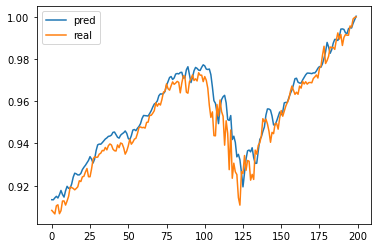

In [26]:
pred.plot()

In [27]:
pred['err'] = pred['pred'] - pred['real']

In [28]:
pred.describe()

,pred,real,err
count,200.000000,200.000000,200.000000
mean,0.955422,0.951186,0.004236
std,0.021395,0.022617,0.005242
min,0.913317,0.906636,-0.008466
25%,0.941075,0.935283,0.001163
50%,0.954996,0.951159,0.003786
75%,0.972914,0.968775,0.005937
max,1.000287,1.000000,0.023629


In [29]:
get_real(pred[['pred', 'real']], scaler_Close)

,pred,real,err
0,227.866230,221.029999,-6.836231
1,227.792230,219.889999,-7.902230
2,229.056220,218.820007,-10.236213
3,230.067759,223.970001,-6.097758
4,228.955812,224.589996,-4.365816
...,...,...,...
195,372.006258,373.850006,1.843748
196,371.690713,372.690002,0.999289
197,376.606266,381.369995,4.763730
198,380.496031,383.010010,2.513979


In [23]:
save(model, 'stock_master')

In [31]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1999-12-31,3.674107,3.553571,3.604911,3.671875,40952800.0,3.178732
2000-01-03,4.017857,3.631696,3.745536,3.997768,133949200.0,3.460857
2000-01-04,3.950893,3.613839,3.866071,3.660714,128094400.0,3.169071
2000-01-05,3.948661,3.678571,3.705357,3.714286,194580400.0,3.215448
2000-01-06,3.821429,3.392857,3.790179,3.392857,191993200.0,2.937188
...,...,...,...,...,...,...
2020-07-06,375.779999,369.869995,370.000000,373.850006,29663900.0,373.850006
2020-07-07,378.619995,372.230011,375.410004,372.690002,28106100.0,372.690002
2020-07-08,381.500000,376.359985,376.720001,381.369995,29273000.0,381.369995


In [ ]:
target = df[['Close']][-1:]
target

In [ ]:
def future_stock(target):
    for s in range(1, 2):
        dataframe['shift_{}'.format(s)] = dataframe[dataframe.columns[0]].shift(s)

In [67]:
target

,Close,shift_1,shift_2
Date,,,
2020-07-10,383.679993,383.01001,381.369995


In [39]:
logg = nplog(target)

In [48]:
sc_test = scaler_Close.transform(logg)

In [58]:
sc_test = sc_test.reshape(1, sc_test.shape[0], sc_test.shape[1])

In [59]:
sc_test

array([[[1.        , 0.99970943]]])

In [60]:
model.predict(sc_test)

array([[1.0028166]], dtype=float32)

In [63]:
real = np.exp(scaler_Close.inverse_transform(model.predict(sc_test)))

In [64]:
real

array([[390.2352]], dtype=float32)